In [1]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion import CatheterMotion


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0015)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None
        self.tip_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        # self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        self.ref_catheter_contour = ref_catheter_contour
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        # self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        self.ref_catheter_centerline = ref_catheter_centerline
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # print('hello')
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        p0 = self.p_start.detach().cpu().numpy()
        para_init = self.para_init.detach().cpu().numpy()
        catheterMotion = CatheterMotion(p0, l=0.2, r=0.01)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, para_init)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            construction_bezier = ConstructionBezier()
            construction_bezier.to(self.gpu_or_cpu)
            construction_bezier.loadRawImage(self.image_save_path_list[i])
            construction_bezier.getBezierCurveCylinder(self.p_start, torch.from_numpy(predicted_paras[i]).to(self.gpu_or_cpu))
            construction_bezier.getCylinderMeshProjImg()
            construction_bezier.getBezierProjImg()
            # build_bezier.draw2DCylinderImage(self.past_frames_list[i], save_img_path_list[i])
            
            loss_contour_m = self.contour_chamfer_loss(construction_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
             
            # motion_model_loss += loss_contour_m.to(self.gpu_or_cpu)
            
            loss_tip_distance_m, self.tip_loss = self.tip_distance_loss(construction_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.centerline_list[i].to(self.gpu_or_cpu)) 
            weight_m = torch.tensor([1.0, 1.0]).to(self.gpu_or_cpu)
            loss_m = loss_contour_m.to(self.gpu_or_cpu) * weight_m[0] + loss_tip_distance_m.to(self.gpu_or_cpu) * weight_m[1]
            motion_model_loss += loss_m.to(self.gpu_or_cpu)
            
        
        weight = torch.tensor([1.0, 1.0, 1.0]).to(self.gpu_or_cpu)
        # weight = torch.tensor([1.0e-5, 1.0, 1.0e-6]).to(self.gpu_or_cpu)
        # loss = loss_contour.to(self.gpu_or_cpu) * weight[0] + loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        loss = loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        
        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)


        # TODO: Plot the loss

        return loss

d:\Programs\miniconda3\envs\catheter\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Camera Intrinsics:
[[883.00220751   0.         320.        ]
 [  0.         883.00220751 240.        ]
 [  0.           0.           1.        ]]
Camera Extrinsics:
[[-1.00000000e+00 -1.22464680e-16  1.49975978e-32  0.00000000e+00]
 [-1.22464680e-16  1.00000000e+00 -1.22464680e-16  0.00000000e+00]
 [ 0.00000000e+00 -1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [2]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector

def bezier_curve_3d(control_points, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 3))

    for i in range(num_points):
        curve[i] = (1 - t[i]) ** 2 * control_points[0] + \
                   2 * (1 - t[i]) * t[i] * control_points[1] + \
                   t[i] ** 2 * control_points[2]

    return curve

In [3]:
def excecute(para_init, i):
    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # ground truth: [2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01 -2.39781477e-01  9.49010349e-01]
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip

    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    loss_history = []
    
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = read_gt_params(cc_specs_path)
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/'
    image_save_path_list = [
    folder_path + 'gt_5_0.0006_-0.0008_0.2_0.01.png',
    folder_path + 'gt_4_0.0006_-0.0006_0.2_0.01.png',
    folder_path + 'gt_3_0.0006_-0.0004_0.2_0.01.png',
    folder_path + 'gt_2_0.0006_-0.0002_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    delta_u_list = [[0, -0.0002], [0, -0.0002], [0, -0.0002], [0, -0.0002]]

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_new3/' \
            + str(i) + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)
        
        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Update the parameters
        optimizer.step()

        # # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        # proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        # d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())
        
        loss_history.append(loss.item())

    # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
    proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
    d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

    # for name, param in catheter_optimize_model.named_parameters():
    #     param_numpy = param.data.cpu().numpy()
    #     filename = f"{name}.npy"
    #     np.save(filename, param_numpy)
    #     print(f"Saved {name} to {filename}")
    
    # Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
    iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
    # print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    fig1.suptitle('2D Tip Euclidean Distance Loss History')
    ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
    ax1.set_xlim([0, len(proj_end_effector_loss_history)])
    # ax1.set_ylim([0, 80])
    ax1.set_ylim(bottom=0)
    ax1.grid(True)
    
    filename = f"{i}_2D_loss.png"
    # Specify the full path where you want to save the file
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test_new3/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig1)  # Close the plot to free up memory


    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    fig2.suptitle('3D Tip Euclidean Distance Loss History')
    ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Euclidean Distance Loss (m)')
    ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
    ax2.set_ylim(bottom=0)
    # ax2.set_ylim([0, 0.05])
    ax2.grid(True)
    
    filename = f"{i}_3D_loss.png"
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test_new3/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig2)  # Close the plot to free up memory
    
    
    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_loss = list(range(len(loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    fig3.suptitle('Total Loss History')
    ax3.plot(iterations_x_axis_loss, loss_history)
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Loss Value')
    ax3.set_xlim([0, len(loss_history)])
    # ax3.set_ylim([0, 3e5])
    ax3.grid(True)
    
    filename = f"{i}_total_loss.png"
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test_new3/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig3)  # Close the plot to free up memory
    
    p_start_np = p_start.numpy()
    result = catheter_optimize_model.para_init.data.cpu().numpy()
    control_points = np.vstack([p_start_np, result.reshape(2, 3)])
    control_points_gt = np.vstack([p_start_np, para_gt_np.reshape(2, 3)])
    control_points_init = np.vstack([p_start_np, para_init.reshape(2, 3)])
    
    # Generate the Bezier curve
    curve = bezier_curve_3d(control_points)
    curve_gt = bezier_curve_3d(control_points_gt)
    curve_init = bezier_curve_3d(control_points_init)

    # Plotting the Bezier curve
    fig4 = plt.figure()
    ax4 = fig4.add_subplot(111, projection='3d')

    # 绘制第一条贝塞尔曲线及其控制点
    ax4.plot(control_points[:, 0], control_points[:, 1], control_points[:, 2], 'ro--')
    ax4.plot(curve[:, 0], curve[:, 1], curve[:, 2], 'r-', label='Optimized Result')

    # 绘制第二条贝塞尔曲线及其控制点
    ax4.plot(control_points_gt[:, 0], control_points_gt[:, 1], control_points_gt[:, 2], 'bo--')
    ax4.plot(curve_gt[:, 0], curve_gt[:, 1], curve_gt[:, 2], 'b-', label='Ground Truth')

    ax4.plot(control_points_init[:, 0], control_points_init[:, 1], control_points_init[:, 2], 'go--')
    ax4.plot(curve_init[:, 0], curve_init[:, 1], curve_init[:, 2], 'g-', label='Initial Guess')

    # Set labels
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')
    ax4.set_title('Optimization Result')
    ax4.legend()

    filename = f"{i}_visualization.png"
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test_new3/{filename}" 
    # Save the figure
    plt.savefig(full_path)

    plt.show()
    plt.close(fig4)

In [4]:
def generate_random_vector(distance_range, size=3):
    """生成指定距离范围内的随机向量"""
    magnitude = np.random.uniform(*distance_range)
    direction = np.random.normal(size=size)
    unit_vector = direction / np.linalg.norm(direction)
    return unit_vector * magnitude

# 定义 ground truth 向量
case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
cc_specs_path = case_naming + '.npy'
ground_truth = read_gt_params(cc_specs_path)
# ground_truth = np.array([0.02007997, 0.00160014, 0.1026283, 0.02973628, -0.04668138, 0.19240253])
print(f"Ground Truth: {ground_truth}\n")

num_vectors = 10
vectors = []

for _ in range(num_vectors):
    # 前三个元素的随机偏移
    offset_front = generate_random_vector((0.001, 0.05), 3)
    # 后三个元素的随机偏移
    offset_back = generate_random_vector((0.015, 0.05), 3)
    
    # 应用偏移并存储向量
    new_vector = ground_truth + np.concatenate((offset_front, offset_back))
    vectors.append(new_vector)

# 根据后三个元素的欧几里得距离从小到大排序
vectors.sort(key=lambda x: np.linalg.norm(x[3:6] - ground_truth[3:6]))

# 打印结果，同时显示与 ground truth 的距离
for vec in vectors:
    distance_front = np.linalg.norm(vec[:3] - ground_truth[:3])
    distance_back = np.linalg.norm(vec[3:6] - ground_truth[3:6])
    print(f"Initial Guess: {vec}")
    print(f"Middle Control Point Deviation : {distance_front:.4f}, Tip Deviation: {distance_back:.4f}\n")

Ground Truth: [ 2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01
 -2.39781477e-01  9.49010349e-01]

Initial Guess: [ 0.02017232 -0.01326246  0.51421414  0.18379015 -0.2208788   0.94016316]
Middle Control Point Deviation : 0.0129, Tip Deviation: 0.0280

Initial Guess: [ 1.41549721e-02  3.91980835e-04  5.07826278e-01  1.83549285e-01
 -2.49802615e-01  9.76031907e-01]
Middle Control Point Deviation : 0.0113, Tip Deviation: 0.0342

Initial Guess: [ 0.0542606  -0.0161309   0.52825357  0.16437347 -0.24397369  0.98364217]
Middle Control Point Deviation : 0.0381, Tip Deviation: 0.0349

Initial Guess: [ 0.01964346 -0.02858719  0.49906619  0.17700996 -0.23552563  0.91634084]
Middle Control Point Deviation : 0.0329, Tip Deviation: 0.0350

Initial Guess: [ 0.02086976 -0.00208629  0.52289566  0.12898762 -0.23869871  0.93026453]
Middle Control Point Deviation : 0.0068, Tip Deviation: 0.0407

Initial Guess: [-4.39989610e-04  4.29718611e-03  5.09007773e-01  1.35381769e-01
 -2.66055605e-01

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:17,  1.39s/it, loss=3.29e+9]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:08,  1.31s/it, loss=9.64e+9]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:08,  1.32s/it, loss=1.11e+10]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:02,  1.28s/it, loss=8.46e+9] 


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:00,  1.27s/it, loss=1.45e+10]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<01:59,  1.27s/it, loss=7.49e+9] 


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<01:59,  1.28s/it, loss=8.91e+9]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:57,  1.28s/it, loss=1.21e+10]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:56,  1.28s/it, loss=1.37e+10]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:12<01:54,  1.27s/it, loss=1.03e+10]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:53,  1.28s/it, loss=2.2e+10] 


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:55,  1.31s/it, loss=1.33e+10]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:53,  1.30s/it, loss=1.07e+10]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:50,  1.29s/it, loss=1.2e+10] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:49,  1.28s/it, loss=1.47e+10]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:20<01:47,  1.28s/it, loss=9.17e+9] 


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:21<01:45,  1.27s/it, loss=9.49e+9]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:23<01:45,  1.28s/it, loss=6.02e+9]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:44,  1.29s/it, loss=6.47e+9]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:25<01:42,  1.28s/it, loss=5.81e+9]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:26<01:40,  1.27s/it, loss=6.04e+9]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:28<01:42,  1.31s/it, loss=5.9e+9] 


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:29<01:48,  1.40s/it, loss=5.79e+9]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:31<01:43,  1.36s/it, loss=5.94e+9]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:32<01:40,  1.34s/it, loss=6.35e+9]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:33<01:37,  1.31s/it, loss=8.49e+9]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:35<01:35,  1.31s/it, loss=1.1e+10]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:36<01:34,  1.31s/it, loss=6.14e+9]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:37<01:31,  1.28s/it, loss=5.94e+9]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:38<01:29,  1.28s/it, loss=6.05e+9]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:40<01:28,  1.29s/it, loss=5.93e+9]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:41<01:28,  1.30s/it, loss=6.87e+9]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:42<01:27,  1.30s/it, loss=5.89e+9]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:44<01:26,  1.32s/it, loss=9.77e+9]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:45<01:26,  1.33s/it, loss=2.06e+10]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:47<01:28,  1.38s/it, loss=5.9e+9]  


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:48<01:24,  1.34s/it, loss=4.82e+9]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:49<01:21,  1.31s/it, loss=4.7e+9] 


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:50<01:20,  1.31s/it, loss=4.91e+9]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:52<01:17,  1.30s/it, loss=6.04e+9]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:53<01:16,  1.29s/it, loss=1.09e+10]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:54<01:14,  1.29s/it, loss=7.32e+9] 


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:55<01:13,  1.29s/it, loss=6.99e+9]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:57<01:12,  1.29s/it, loss=6.95e+9]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:58<01:10,  1.29s/it, loss=7.68e+9]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [00:59<01:09,  1.28s/it, loss=9.68e+9]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:01<01:08,  1.29s/it, loss=2.1e+10]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:02<01:06,  1.29s/it, loss=6.17e+9]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:03<01:04,  1.27s/it, loss=5.28e+9]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:04<01:03,  1.27s/it, loss=4.98e+9]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:06<01:03,  1.29s/it, loss=4.83e+9]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:07<01:01,  1.29s/it, loss=4.74e+9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:08<01:01,  1.32s/it, loss=4.69e+9]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:10<01:00,  1.31s/it, loss=4.69e+9]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:11<00:58,  1.30s/it, loss=4.77e+9]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:12<00:57,  1.31s/it, loss=4.95e+9]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:14<00:55,  1.30s/it, loss=5.29e+9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:15<00:54,  1.29s/it, loss=5.86e+9]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:16<00:53,  1.29s/it, loss=6.44e+9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:17<00:51,  1.30s/it, loss=6.11e+9]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:19<00:50,  1.29s/it, loss=5.42e+9]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:20<00:48,  1.29s/it, loss=4.96e+9]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:21<00:47,  1.28s/it, loss=4.71e+9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:23<00:46,  1.28s/it, loss=4.58e+9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:24<00:44,  1.27s/it, loss=4.53e+9]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:25<00:43,  1.28s/it, loss=4.55e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:26<00:42,  1.29s/it, loss=4.62e+9]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:28<00:41,  1.29s/it, loss=4.71e+9]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:29<00:40,  1.30s/it, loss=4.81e+9]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:30<00:38,  1.29s/it, loss=4.87e+9]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:32<00:37,  1.28s/it, loss=4.89e+9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:33<00:36,  1.29s/it, loss=4.87e+9]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:34<00:34,  1.28s/it, loss=4.84e+9]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:35<00:33,  1.28s/it, loss=4.81e+9]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:37<00:33,  1.33s/it, loss=4.76e+9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:38<00:31,  1.33s/it, loss=4.7e+9] 


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:39<00:30,  1.31s/it, loss=4.65e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:41<00:28,  1.30s/it, loss=4.6e+9] 


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:42<00:27,  1.29s/it, loss=4.58e+9]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:43<00:26,  1.31s/it, loss=4.58e+9]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:45<00:24,  1.30s/it, loss=4.62e+9]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:46<00:23,  1.29s/it, loss=4.68e+9]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:47<00:22,  1.30s/it, loss=4.74e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:49<00:21,  1.32s/it, loss=4.79e+9]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:50<00:19,  1.32s/it, loss=4.79e+9]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:51<00:18,  1.31s/it, loss=4.75e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:52<00:16,  1.30s/it, loss=4.69e+9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:54<00:15,  1.30s/it, loss=4.65e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:55<00:14,  1.30s/it, loss=4.62e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:56<00:12,  1.29s/it, loss=4.61e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [01:58<00:11,  1.29s/it, loss=4.62e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [01:59<00:10,  1.29s/it, loss=4.63e+9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:00<00:09,  1.30s/it, loss=4.64e+9]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:02<00:08,  1.35s/it, loss=4.66e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:03<00:06,  1.36s/it, loss=4.67e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:04<00:05,  1.35s/it, loss=4.68e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:06<00:03,  1.33s/it, loss=4.69e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:07<00:02,  1.31s/it, loss=4.7e+9] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:08<00:01,  1.29s/it, loss=4.69e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it, loss=4.66e+9]


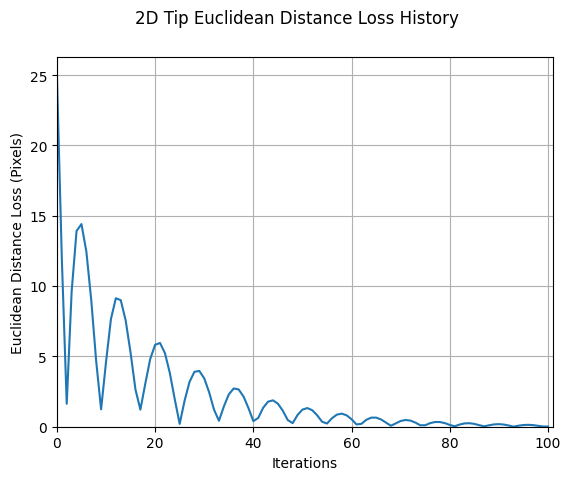

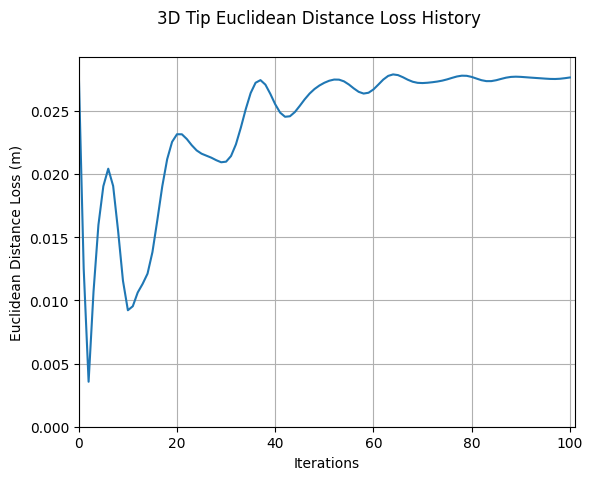

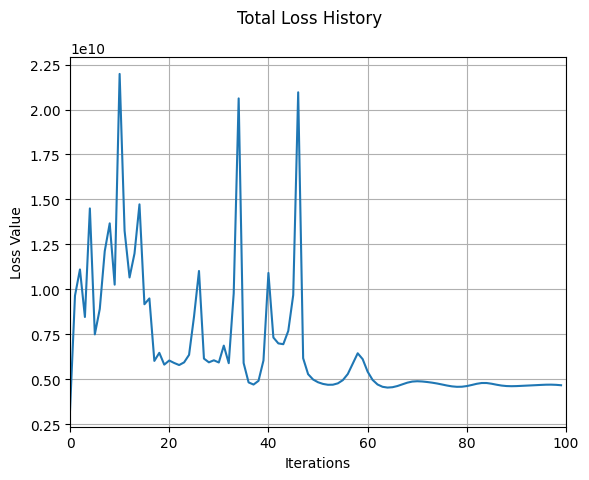

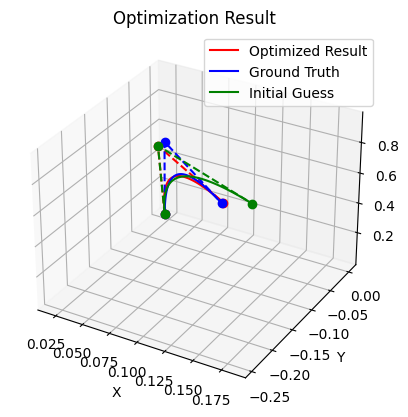

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:08,  1.29s/it, loss=3.92e+9]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:11,  1.35s/it, loss=4.66e+9]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:07,  1.32s/it, loss=1.19e+10]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:04,  1.30s/it, loss=5.04e+9] 


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:03,  1.30s/it, loss=4.26e+9]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:02,  1.31s/it, loss=4.08e+9]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:00,  1.29s/it, loss=4.09e+9]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:59,  1.30s/it, loss=4.21e+9]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:57,  1.29s/it, loss=4.49e+9]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:12<01:56,  1.29s/it, loss=5.1e+9]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:54,  1.29s/it, loss=6.56e+9]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:52,  1.28s/it, loss=7.5e+9] 


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:50,  1.27s/it, loss=5.89e+9]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:51,  1.29s/it, loss=5.13e+9]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:50,  1.30s/it, loss=4.87e+9]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:20<01:49,  1.30s/it, loss=4.93e+9]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:48,  1.31s/it, loss=5.58e+9]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:23<01:47,  1.32s/it, loss=3.91e+10]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:45,  1.30s/it, loss=9.19e+9] 


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:25<01:43,  1.29s/it, loss=7e+9]   


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:27<01:41,  1.29s/it, loss=1.54e+10]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:28<01:40,  1.29s/it, loss=7.2e+9]  


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:29<01:38,  1.29s/it, loss=1.12e+10]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:31<01:36,  1.28s/it, loss=1.05e+10]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:32<01:36,  1.28s/it, loss=9.62e+9] 


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:33<01:35,  1.30s/it, loss=9.92e+9]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:34<01:34,  1.29s/it, loss=1.02e+10]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:36<01:33,  1.29s/it, loss=7.99e+9] 


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:37<01:31,  1.28s/it, loss=6.68e+9]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:38<01:31,  1.31s/it, loss=6.26e+9]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:40<01:30,  1.30s/it, loss=8.57e+9]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:41<01:37,  1.44s/it, loss=2.75e+10]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:43<01:34,  1.41s/it, loss=5.93e+9] 


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:44<01:32,  1.39s/it, loss=6.8e+9] 


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:45<01:28,  1.36s/it, loss=7e+9]  


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:47<01:25,  1.34s/it, loss=7.23e+9]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:48<01:23,  1.32s/it, loss=6.92e+9]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:49<01:22,  1.33s/it, loss=1.1e+10]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:51<01:20,  1.31s/it, loss=5.85e+9]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:52<01:19,  1.32s/it, loss=3.69e+10]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:53<01:17,  1.31s/it, loss=5.99e+9] 


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:55<01:15,  1.31s/it, loss=5.93e+9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:56<01:14,  1.30s/it, loss=8.55e+9]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:57<01:12,  1.30s/it, loss=6.22e+9]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:58<01:11,  1.30s/it, loss=5.86e+9]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:00<01:10,  1.31s/it, loss=5.98e+9]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:01<01:12,  1.36s/it, loss=5.91e+9]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:03<01:09,  1.34s/it, loss=5.89e+9]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:04<01:07,  1.33s/it, loss=7.1e+9] 


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:05<01:06,  1.33s/it, loss=8.64e+9]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:07<01:06,  1.36s/it, loss=6.61e+9]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:08<01:04,  1.33s/it, loss=6.97e+9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:09<01:02,  1.32s/it, loss=1.4e+10]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:11<01:02,  1.36s/it, loss=8.48e+9]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:12<01:00,  1.34s/it, loss=7.09e+9]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:13<00:58,  1.32s/it, loss=7.47e+9]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:15<00:57,  1.34s/it, loss=1.2e+10]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:16<00:56,  1.33s/it, loss=1.2e+10]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:17<00:54,  1.32s/it, loss=8.37e+9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:18<00:52,  1.31s/it, loss=8.79e+9]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:20<00:51,  1.32s/it, loss=1.39e+10]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:21<00:49,  1.31s/it, loss=6.41e+10]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:22<00:48,  1.30s/it, loss=2.12e+11]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:24<00:47,  1.32s/it, loss=1.06e+10]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:25<00:45,  1.30s/it, loss=7.16e+9] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:26<00:45,  1.33s/it, loss=6.45e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:28<00:45,  1.38s/it, loss=6.36e+9]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:29<00:43,  1.36s/it, loss=6.78e+9]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:31<00:41,  1.35s/it, loss=8.7e+9] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:32<00:40,  1.34s/it, loss=5.29e+10]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:33<00:38,  1.34s/it, loss=2.58e+10]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:34<00:36,  1.31s/it, loss=1.41e+10]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:36<00:35,  1.31s/it, loss=7.33e+9] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:37<00:33,  1.30s/it, loss=6.32e+9]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:38<00:32,  1.31s/it, loss=6.08e+9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:40<00:31,  1.31s/it, loss=6.16e+9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:41<00:30,  1.31s/it, loss=6.62e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:43<00:36,  1.66s/it, loss=8.09e+9]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:45<00:32,  1.54s/it, loss=1.19e+10]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:46<00:29,  1.49s/it, loss=1.13e+10]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:47<00:27,  1.45s/it, loss=7.91e+9] 


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:49<00:25,  1.41s/it, loss=6.67e+9]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:50<00:23,  1.38s/it, loss=6.27e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:51<00:21,  1.37s/it, loss=6.21e+9]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:53<00:20,  1.37s/it, loss=6.4e+9] 


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:54<00:18,  1.34s/it, loss=6.86e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:55<00:17,  1.34s/it, loss=7.49e+9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:57<00:15,  1.33s/it, loss=7.71e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:58<00:14,  1.33s/it, loss=7.27e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:59<00:13,  1.32s/it, loss=6.79e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:01<00:11,  1.30s/it, loss=6.54e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:02<00:11,  1.38s/it, loss=6.49e+9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:03<00:09,  1.35s/it, loss=6.59e+9]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:05<00:07,  1.33s/it, loss=6.76e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:06<00:06,  1.31s/it, loss=6.87e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:07<00:05,  1.30s/it, loss=6.83e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:09<00:03,  1.31s/it, loss=6.72e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:10<00:02,  1.31s/it, loss=6.64e+9]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:11<00:01,  1.31s/it, loss=6.65e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:12<00:00,  1.33s/it, loss=6.74e+9]


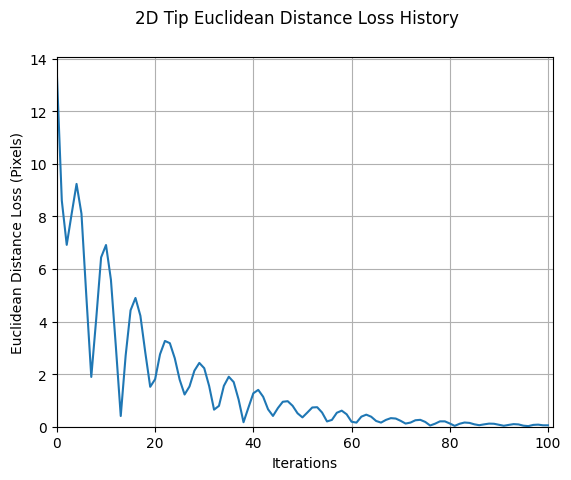

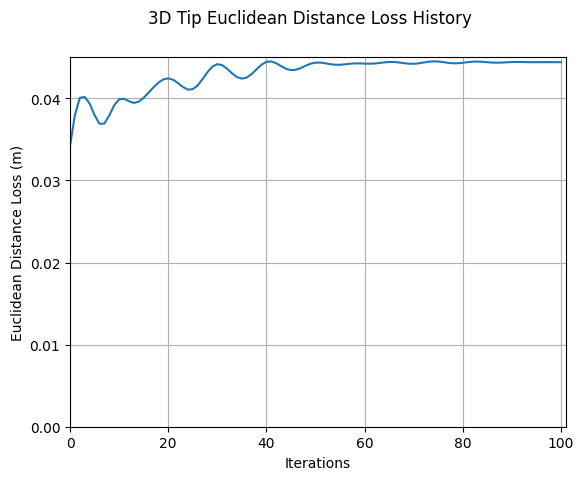

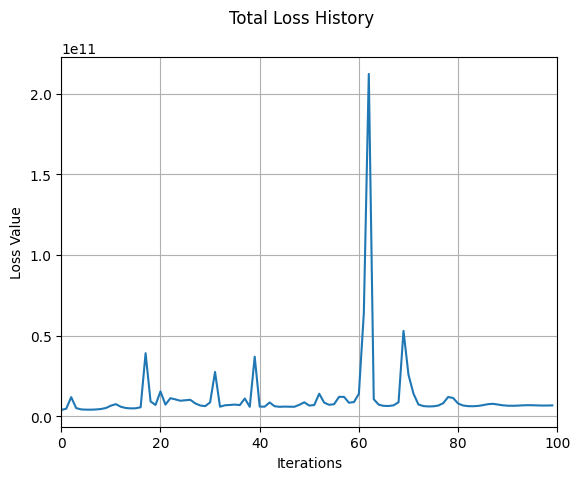

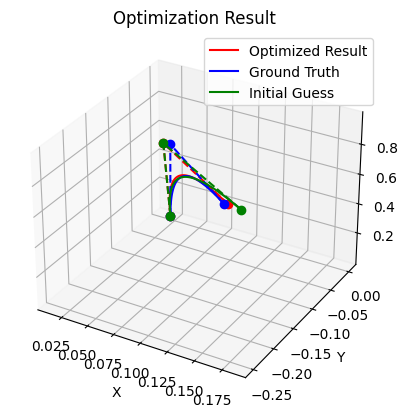

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.26s/it, loss=2.79e+10]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:05,  1.28s/it, loss=1.05e+10]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:05,  1.29s/it, loss=5.52e+9] 


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:03,  1.29s/it, loss=1.52e+10]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:02,  1.29s/it, loss=8.27e+9] 


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:02,  1.31s/it, loss=8.17e+9]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:02,  1.32s/it, loss=7.19e+9]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:59,  1.30s/it, loss=7.22e+9]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:58,  1.31s/it, loss=6.13e+9]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<01:58,  1.32s/it, loss=1.01e+10]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:57,  1.32s/it, loss=5.7e+9]  


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:55,  1.31s/it, loss=8.95e+9]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:54,  1.31s/it, loss=4.26e+10]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:53,  1.32s/it, loss=7.67e+9] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:51,  1.32s/it, loss=7.65e+9]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:20<01:49,  1.30s/it, loss=8.79e+9]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:48,  1.31s/it, loss=7.03e+9]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:23<01:47,  1.31s/it, loss=1.62e+11]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:46,  1.31s/it, loss=1.04e+10]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:45,  1.31s/it, loss=1.29e+10]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:27<01:53,  1.44s/it, loss=7.11e+9] 


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:49,  1.41s/it, loss=9.95e+9]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:45,  1.38s/it, loss=8.07e+9]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:31<01:42,  1.35s/it, loss=7.66e+9]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:39,  1.32s/it, loss=9.15e+9]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:34<01:37,  1.32s/it, loss=3.24e+10]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:35<01:36,  1.32s/it, loss=6.73e+9] 


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:36,  1.34s/it, loss=6.92e+9]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:38<01:34,  1.33s/it, loss=6.76e+9]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:39<01:33,  1.34s/it, loss=7.7e+9] 


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:31,  1.33s/it, loss=9.01e+9]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:30,  1.33s/it, loss=8.1e+9] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:43<01:29,  1.33s/it, loss=7.68e+9]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:45<01:27,  1.32s/it, loss=8.78e+9]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:46<01:29,  1.37s/it, loss=9.27e+9]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:47<01:26,  1.35s/it, loss=1.12e+10]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:49<01:23,  1.32s/it, loss=8.36e+9] 


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:50<01:22,  1.33s/it, loss=2.35e+10]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:51<01:20,  1.31s/it, loss=9.33e+9] 


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:52<01:18,  1.31s/it, loss=9.26e+9]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:54<01:16,  1.29s/it, loss=7.85e+9]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:55<01:14,  1.29s/it, loss=8.03e+9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:56<01:13,  1.29s/it, loss=1.24e+10]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:58<01:12,  1.29s/it, loss=1.01e+10]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:59<01:10,  1.29s/it, loss=9.08e+9] 


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:00<01:09,  1.29s/it, loss=9.59e+9]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:02<01:09,  1.31s/it, loss=2.26e+10]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:03<01:07,  1.30s/it, loss=8.43e+9] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:04<01:05,  1.29s/it, loss=7.89e+9]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:05<01:04,  1.30s/it, loss=8.11e+9]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:07<01:05,  1.35s/it, loss=9.97e+9]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:08<01:03,  1.33s/it, loss=3.37e+11]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:09<01:01,  1.32s/it, loss=2.22e+10]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:11<01:00,  1.32s/it, loss=1.53e+10]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:12<00:58,  1.31s/it, loss=8.71e+9] 


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:13<00:57,  1.30s/it, loss=7.9e+9] 


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:15<00:55,  1.29s/it, loss=7.84e+9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:16<00:54,  1.29s/it, loss=8.27e+9]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:17<00:52,  1.28s/it, loss=9.99e+9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:18<00:51,  1.29s/it, loss=1.41e+10]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:20<00:50,  1.28s/it, loss=1.17e+10]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:21<00:49,  1.30s/it, loss=8.78e+9] 


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:22<00:48,  1.31s/it, loss=7.92e+9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:24<00:46,  1.29s/it, loss=7.76e+9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:25<00:44,  1.28s/it, loss=7.91e+9]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:26<00:44,  1.30s/it, loss=8.59e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:27<00:42,  1.29s/it, loss=1e+10]  


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:29<00:41,  1.28s/it, loss=1.03e+10]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:30<00:39,  1.27s/it, loss=8.84e+9] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:31<00:38,  1.28s/it, loss=8e+9]   


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:33<00:37,  1.30s/it, loss=7.75e+9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:34<00:38,  1.36s/it, loss=7.81e+9]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:35<00:36,  1.33s/it, loss=8.17e+9]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:37<00:34,  1.32s/it, loss=8.96e+9]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:38<00:32,  1.31s/it, loss=9.44e+9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:39<00:31,  1.29s/it, loss=8.76e+9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:41<00:29,  1.30s/it, loss=8.08e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:42<00:28,  1.32s/it, loss=7.8e+9] 


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:43<00:27,  1.32s/it, loss=7.8e+9]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:45<00:26,  1.32s/it, loss=8.04e+9]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:46<00:25,  1.33s/it, loss=8.54e+9]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:47<00:23,  1.32s/it, loss=8.89e+9]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:49<00:22,  1.32s/it, loss=8.58e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:50<00:21,  1.33s/it, loss=8.1e+9] 


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:51<00:19,  1.31s/it, loss=7.86e+9]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:52<00:18,  1.30s/it, loss=7.85e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:54<00:16,  1.31s/it, loss=8.03e+9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:55<00:15,  1.30s/it, loss=8.36e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:56<00:14,  1.30s/it, loss=8.56e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:58<00:12,  1.29s/it, loss=8.38e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [01:59<00:11,  1.30s/it, loss=8.08e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:00<00:10,  1.28s/it, loss=7.92e+9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:01<00:08,  1.28s/it, loss=7.92e+9]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:03<00:07,  1.29s/it, loss=8.07e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:04<00:06,  1.30s/it, loss=8.28e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:05<00:05,  1.30s/it, loss=8.36e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:07<00:03,  1.29s/it, loss=8.23e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:08<00:02,  1.38s/it, loss=8.05e+9]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:10<00:01,  1.35s/it, loss=7.97e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it, loss=8e+9]  


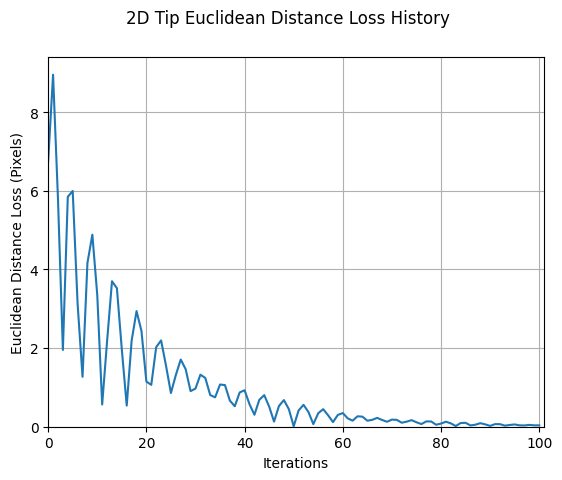

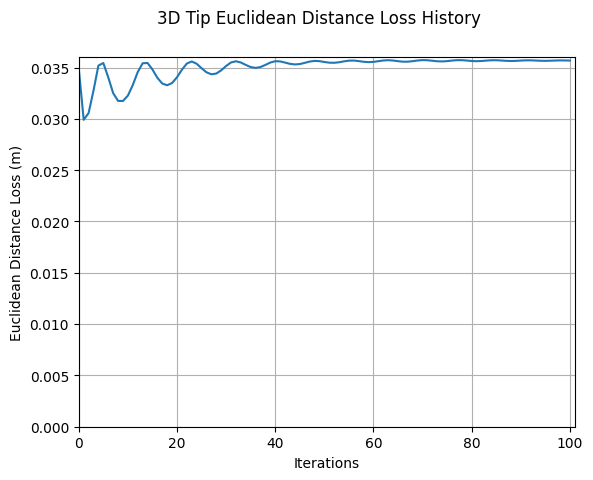

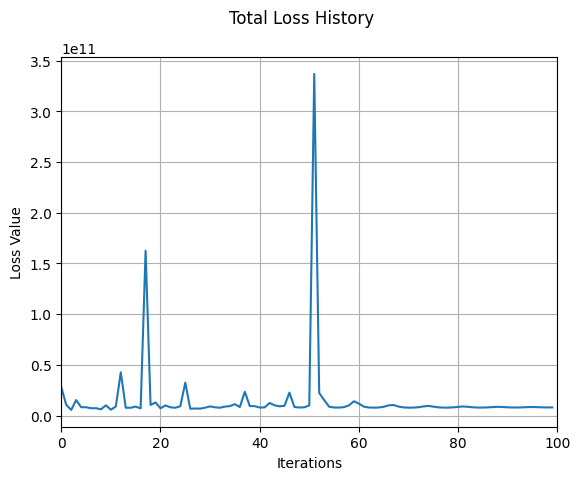

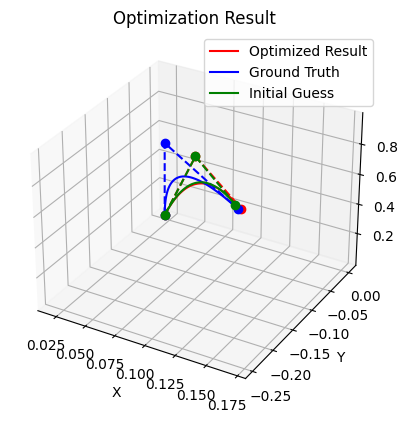

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:02,  1.24s/it, loss=7.39e+9]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:03,  1.26s/it, loss=2.15e+10]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:02,  1.26s/it, loss=1.48e+10]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:02,  1.27s/it, loss=9.81e+9] 


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:02,  1.29s/it, loss=1.46e+10]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:00,  1.28s/it, loss=1.16e+10]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:08<01:58,  1.28s/it, loss=1.65e+10]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:58,  1.29s/it, loss=1.26e+10]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:57,  1.29s/it, loss=1.2e+10] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:12<01:57,  1.30s/it, loss=1.17e+10]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:58,  1.33s/it, loss=9.05e+9] 


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:58,  1.35s/it, loss=8.91e+9]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:55,  1.33s/it, loss=8.53e+9]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:52,  1.31s/it, loss=1.12e+10]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:50,  1.30s/it, loss=9.65e+9] 


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:20<01:49,  1.31s/it, loss=9.43e+9]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:48,  1.31s/it, loss=1.16e+10]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:23<01:47,  1.31s/it, loss=1.61e+10]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:45,  1.31s/it, loss=1.47e+10]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:44,  1.31s/it, loss=1.74e+10]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:27<01:42,  1.30s/it, loss=1.79e+10]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:28<01:40,  1.29s/it, loss=2.29e+10]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:29<01:38,  1.29s/it, loss=1.36e+10]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:31<01:38,  1.29s/it, loss=1.54e+10]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:32<01:38,  1.32s/it, loss=1.03e+10]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:33<01:37,  1.31s/it, loss=2.59e+10]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:35<01:36,  1.32s/it, loss=2.65e+10]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:36<01:34,  1.32s/it, loss=1e+10]   


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:38<01:43,  1.46s/it, loss=1.13e+10]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:39<01:38,  1.41s/it, loss=1.78e+10]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:40<01:34,  1.36s/it, loss=3.08e+10]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:32,  1.35s/it, loss=4.8e+10] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:43<01:30,  1.35s/it, loss=1.07e+10]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:44<01:27,  1.33s/it, loss=1.31e+10]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:46<01:26,  1.32s/it, loss=1.2e+10] 


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:47<01:25,  1.33s/it, loss=1.12e+11]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:48<01:24,  1.34s/it, loss=2.19e+10]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:50<01:26,  1.39s/it, loss=1.68e+10]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:51<01:22,  1.35s/it, loss=1.46e+10]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:52<01:19,  1.33s/it, loss=1.38e+10]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:54<01:17,  1.32s/it, loss=1.65e+10]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:55<01:16,  1.32s/it, loss=2.17e+10]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:56<01:13,  1.30s/it, loss=4.42e+10]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:58<01:15,  1.36s/it, loss=3.26e+10]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:59<01:13,  1.34s/it, loss=1.29e+10]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:00<01:11,  1.32s/it, loss=1.47e+11]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:02<01:09,  1.30s/it, loss=1.1e+10] 


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:03<01:08,  1.31s/it, loss=1.12e+10]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:04<01:05,  1.29s/it, loss=1.15e+10]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:05<01:04,  1.28s/it, loss=2.45e+10]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:07<01:02,  1.29s/it, loss=2.27e+10]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:08<01:02,  1.29s/it, loss=6.39e+10]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:09<01:00,  1.30s/it, loss=9.03e+10]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:11<00:59,  1.29s/it, loss=2.92e+10]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:12<00:57,  1.29s/it, loss=5.55e+10]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:13<00:56,  1.29s/it, loss=1.82e+10]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:14<00:56,  1.31s/it, loss=1.26e+10]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:16<00:54,  1.30s/it, loss=1.37e+10]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:17<00:53,  1.30s/it, loss=1.51e+10]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:18<00:52,  1.30s/it, loss=2.48e+10]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:20<00:51,  1.31s/it, loss=1.15e+10]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:21<00:49,  1.30s/it, loss=1.96e+10]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:22<00:50,  1.37s/it, loss=1.58e+10]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:24<00:48,  1.34s/it, loss=1.18e+11]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:25<00:46,  1.33s/it, loss=3e+10]   


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:26<00:44,  1.32s/it, loss=2.11e+10]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:28<00:43,  1.31s/it, loss=2.31e+10]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:29<00:41,  1.31s/it, loss=1.29e+10]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:30<00:40,  1.31s/it, loss=1.18e+10]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:32<00:38,  1.30s/it, loss=1.15e+10]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:33<00:37,  1.29s/it, loss=1.15e+10]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:34<00:36,  1.29s/it, loss=1.15e+10]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:35<00:35,  1.30s/it, loss=1.17e+10]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:37<00:33,  1.29s/it, loss=1.21e+10]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:38<00:32,  1.29s/it, loss=1.32e+10]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:39<00:31,  1.33s/it, loss=1.6e+10] 


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:41<00:30,  1.34s/it, loss=2.96e+10]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:42<00:29,  1.32s/it, loss=2.73e+10]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:43<00:27,  1.32s/it, loss=1.46e+10]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:45<00:26,  1.32s/it, loss=1.22e+10]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:46<00:25,  1.32s/it, loss=1.17e+10]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:47<00:23,  1.33s/it, loss=1.2e+10] 


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:49<00:22,  1.32s/it, loss=1.2e+10]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:50<00:21,  1.32s/it, loss=1.17e+10]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:51<00:19,  1.31s/it, loss=1.2e+10] 


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:53<00:18,  1.31s/it, loss=1.3e+10]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:54<00:18,  1.41s/it, loss=1.43e+10]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:56<00:16,  1.39s/it, loss=1.4e+10] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:57<00:15,  1.39s/it, loss=1.29e+10]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:58<00:13,  1.38s/it, loss=1.22e+10]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:00<00:12,  1.37s/it, loss=1.18e+10]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:01<00:10,  1.37s/it, loss=1.17e+10]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:02<00:09,  1.41s/it, loss=1.17e+10]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:04<00:08,  1.36s/it, loss=1.17e+10]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:05<00:06,  1.33s/it, loss=1.18e+10]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:06<00:05,  1.32s/it, loss=1.2e+10] 


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:08<00:03,  1.30s/it, loss=1.22e+10]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:09<00:02,  1.30s/it, loss=1.24e+10]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:10<00:01,  1.30s/it, loss=1.24e+10]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=1.23e+10]


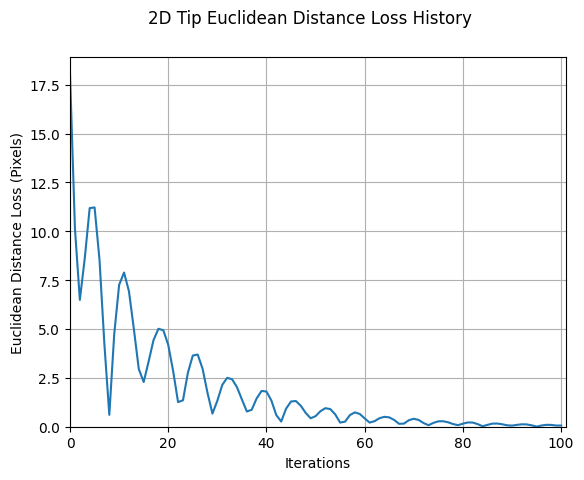

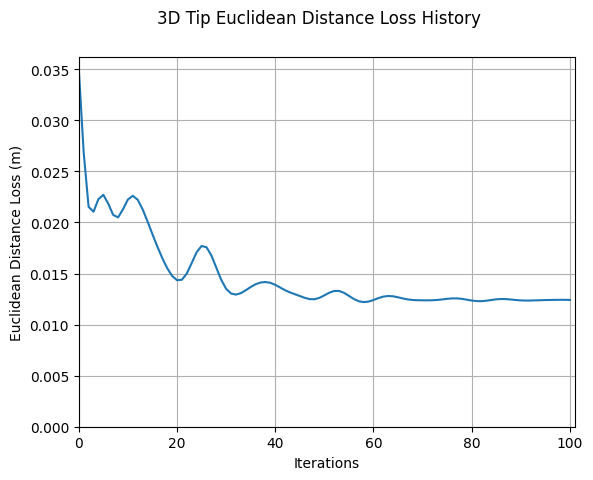

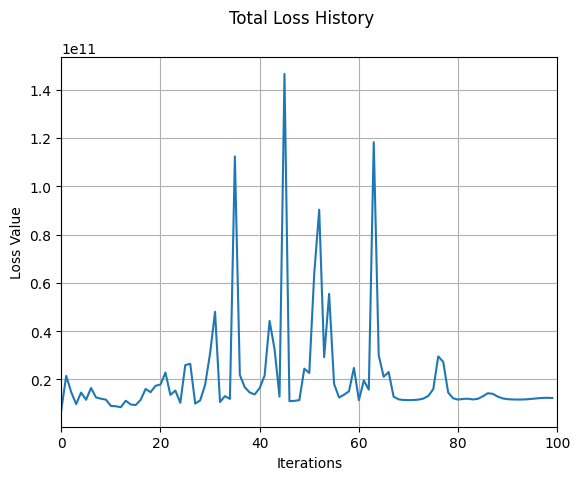

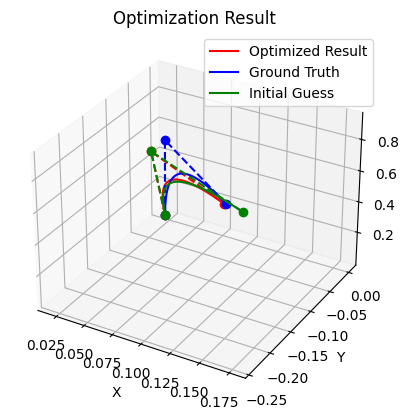

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:23,  1.45s/it, loss=3.27e+9]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:12,  1.35s/it, loss=1.46e+9]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:06,  1.30s/it, loss=1.38e+9]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:03,  1.29s/it, loss=1.22e+9]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:01,  1.28s/it, loss=6e+8]   


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<02:03,  1.31s/it, loss=5.16e+8]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:02,  1.32s/it, loss=4.96e+8]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:06,  1.38s/it, loss=5.25e+8]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<02:01,  1.34s/it, loss=6.07e+8]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<01:59,  1.33s/it, loss=8.53e+8]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:57,  1.32s/it, loss=1.06e+9]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:55,  1.31s/it, loss=1.65e+9]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:54,  1.32s/it, loss=3.68e+9]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:54,  1.33s/it, loss=1.49e+9]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<02:03,  1.45s/it, loss=1.75e+9]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:59,  1.42s/it, loss=1.49e+10]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:55,  1.39s/it, loss=2.86e+9] 


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:55,  1.41s/it, loss=8.01e+9]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:51,  1.38s/it, loss=1.93e+9]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:50,  1.39s/it, loss=1.53e+9]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:46,  1.35s/it, loss=1.61e+9]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:45,  1.36s/it, loss=3.59e+9]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:52,  1.46s/it, loss=1.57e+10]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:33<01:58,  1.55s/it, loss=3.15e+9] 


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:57,  1.56s/it, loss=4.43e+9]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:36<01:52,  1.52s/it, loss=2.94e+9]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:37<01:51,  1.53s/it, loss=3.28e+9]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:39<01:44,  1.46s/it, loss=3.71e+9]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:40<01:39,  1.40s/it, loss=1.72e+9]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:35,  1.36s/it, loss=1.53e+9]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:31,  1.33s/it, loss=1.74e+9]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:44<01:28,  1.31s/it, loss=5.35e+10]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:26,  1.29s/it, loss=2.36e+9] 


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:24,  1.28s/it, loss=3.02e+9]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:23,  1.28s/it, loss=3.8e+9] 


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:22,  1.29s/it, loss=2.87e+9]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:20,  1.28s/it, loss=2.38e+9]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:18,  1.27s/it, loss=3.28e+9]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:18,  1.29s/it, loss=2.62e+9]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:16,  1.28s/it, loss=1.85e+9]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:15,  1.28s/it, loss=1.67e+9]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:17,  1.33s/it, loss=1.61e+9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:16,  1.33s/it, loss=1.6e+9] 


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:15,  1.35s/it, loss=1.62e+9]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:01<01:15,  1.37s/it, loss=1.71e+9]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:15,  1.40s/it, loss=2.01e+9]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:04<01:14,  1.41s/it, loss=5.59e+9]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:05<01:11,  1.37s/it, loss=2.57e+9]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:07,  1.33s/it, loss=2.45e+9]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:05,  1.31s/it, loss=2.9e+9] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:09<01:08,  1.39s/it, loss=3.55e+9]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:08,  1.43s/it, loss=3.53e+9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:12<01:06,  1.41s/it, loss=2.95e+9]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:13<01:03,  1.38s/it, loss=2.54e+9]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:01,  1.37s/it, loss=2.4e+9] 


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:16<00:59,  1.35s/it, loss=2.65e+9]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:17<00:56,  1.32s/it, loss=4.42e+9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:54,  1.30s/it, loss=1.27e+10]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:20<00:52,  1.29s/it, loss=6.02e+9] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:21<00:54,  1.36s/it, loss=2.69e+10]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:22<00:53,  1.37s/it, loss=4.17e+9] 


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:24<00:51,  1.37s/it, loss=2.72e+9]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:25<00:49,  1.34s/it, loss=2.43e+9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:26<00:48,  1.35s/it, loss=2.44e+9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:28<00:46,  1.32s/it, loss=2.6e+9] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:29<00:44,  1.30s/it, loss=2.84e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:30<00:42,  1.30s/it, loss=2.98e+9]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:32<00:41,  1.29s/it, loss=2.87e+9]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:33<00:40,  1.31s/it, loss=2.64e+9]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:34<00:38,  1.29s/it, loss=2.47e+9]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:36<00:38,  1.33s/it, loss=2.42e+9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:37<00:37,  1.33s/it, loss=2.44e+9]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:38<00:35,  1.31s/it, loss=2.5e+9] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:40<00:34,  1.32s/it, loss=2.53e+9]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:41<00:32,  1.32s/it, loss=2.5e+9] 


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:42<00:31,  1.31s/it, loss=2.45e+9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:43<00:29,  1.30s/it, loss=2.42e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:45<00:28,  1.30s/it, loss=2.43e+9]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:46<00:27,  1.29s/it, loss=2.5e+9] 


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:47<00:25,  1.29s/it, loss=2.59e+9]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:49<00:24,  1.28s/it, loss=2.65e+9]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:50<00:22,  1.28s/it, loss=2.64e+9]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:51<00:23,  1.37s/it, loss=2.58e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:53<00:21,  1.34s/it, loss=2.51e+9]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:54<00:19,  1.32s/it, loss=2.46e+9]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:55<00:18,  1.30s/it, loss=2.43e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:56<00:16,  1.29s/it, loss=2.42e+9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:58<00:15,  1.29s/it, loss=2.42e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:59<00:14,  1.28s/it, loss=2.42e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:00<00:12,  1.28s/it, loss=2.42e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:02<00:11,  1.28s/it, loss=2.43e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:03<00:10,  1.28s/it, loss=2.45e+9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:04<00:08,  1.28s/it, loss=2.49e+9]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:05<00:07,  1.27s/it, loss=2.52e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:07<00:06,  1.29s/it, loss=2.54e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:08<00:05,  1.28s/it, loss=2.54e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:09<00:03,  1.29s/it, loss=2.52e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:11<00:02,  1.30s/it, loss=2.49e+9]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:12<00:01,  1.30s/it, loss=2.46e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:13<00:00,  1.34s/it, loss=2.44e+9]


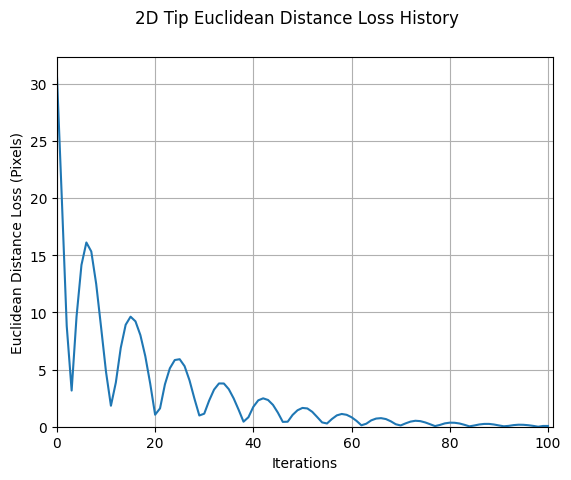

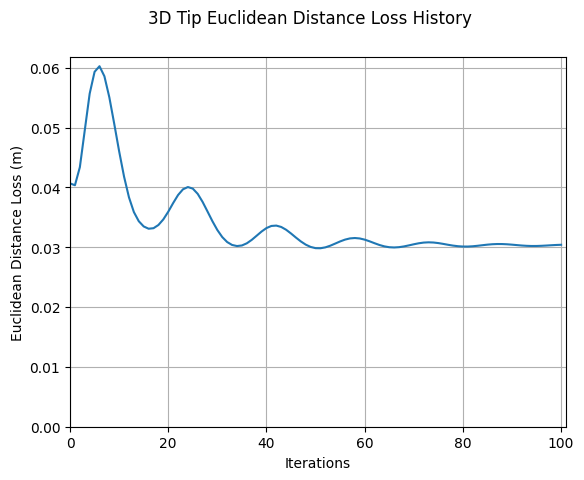

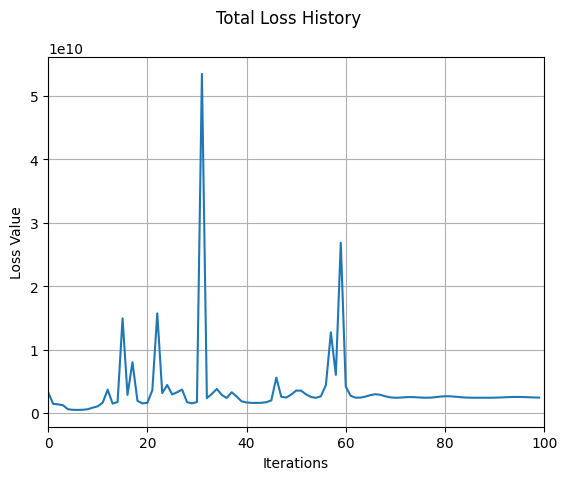

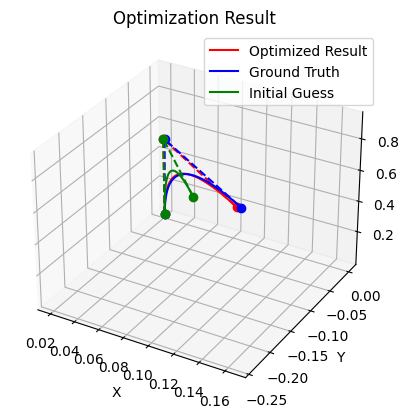

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:03,  1.25s/it, loss=1.75e+10]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:03,  1.26s/it, loss=9.48e+9] 


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:01,  1.25s/it, loss=3.46e+10]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:00,  1.25s/it, loss=6.36e+9] 


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<01:57,  1.24s/it, loss=9.07e+9]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<01:57,  1.25s/it, loss=5.48e+9]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:08<01:56,  1.25s/it, loss=6.02e+9]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:56,  1.27s/it, loss=1.14e+10]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:54,  1.26s/it, loss=1.3e+10] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<02:05,  1.40s/it, loss=8.26e+9]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:59,  1.34s/it, loss=7.27e+9]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:57,  1.33s/it, loss=6.82e+9]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:53,  1.31s/it, loss=1.04e+10]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:51,  1.29s/it, loss=5.25e+9] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:48,  1.28s/it, loss=4.3e+9] 


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:20<01:47,  1.28s/it, loss=4.03e+9]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:21<01:46,  1.28s/it, loss=3.92e+9]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:23<01:45,  1.28s/it, loss=3.88e+9]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:43,  1.28s/it, loss=3.88e+9]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:25<01:43,  1.29s/it, loss=3.91e+9]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:27<01:45,  1.34s/it, loss=3.94e+9]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:28<01:43,  1.33s/it, loss=3.97e+9]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:29<01:41,  1.32s/it, loss=3.99e+9]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:31<01:38,  1.30s/it, loss=4.01e+9]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:32<01:36,  1.29s/it, loss=4.03e+9]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:33<01:35,  1.29s/it, loss=4.05e+9]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:34<01:33,  1.28s/it, loss=4.06e+9]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:36<01:32,  1.29s/it, loss=4.05e+9]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:37<01:31,  1.28s/it, loss=4.04e+9]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:38<01:30,  1.29s/it, loss=4.03e+9]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:40<01:28,  1.28s/it, loss=4.03e+9]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:41<01:26,  1.27s/it, loss=4.05e+9]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:42<01:25,  1.28s/it, loss=4.08e+9]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:43<01:25,  1.29s/it, loss=4.12e+9]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:45<01:26,  1.34s/it, loss=4.16e+9]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:46<01:24,  1.32s/it, loss=4.17e+9]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:47<01:22,  1.31s/it, loss=4.16e+9]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:49<01:20,  1.30s/it, loss=4.14e+9]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:50<01:18,  1.29s/it, loss=4.12e+9]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:51<01:16,  1.28s/it, loss=4.11e+9]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:52<01:15,  1.28s/it, loss=4.11e+9]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:54<01:13,  1.27s/it, loss=4.12e+9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:55<01:12,  1.28s/it, loss=4.14e+9]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:56<01:11,  1.28s/it, loss=4.17e+9]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:58<01:10,  1.28s/it, loss=4.21e+9]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [00:59<01:09,  1.28s/it, loss=4.26e+9]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:00<01:07,  1.28s/it, loss=4.31e+9]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:01<01:06,  1.27s/it, loss=4.35e+9]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:03<01:04,  1.27s/it, loss=4.37e+9]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:04<01:03,  1.26s/it, loss=4.37e+9]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:05<01:02,  1.27s/it, loss=4.34e+9]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:07<01:04,  1.34s/it, loss=4.32e+9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:08<01:01,  1.32s/it, loss=4.29e+9]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:09<00:59,  1.30s/it, loss=4.28e+9]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:10<00:57,  1.29s/it, loss=4.28e+9]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:12<00:56,  1.28s/it, loss=4.3e+9] 


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:13<00:54,  1.28s/it, loss=4.33e+9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:14<00:54,  1.29s/it, loss=4.37e+9]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:16<00:52,  1.29s/it, loss=4.42e+9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:17<00:51,  1.30s/it, loss=4.45e+9]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:18<00:51,  1.32s/it, loss=4.47e+9]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:20<00:49,  1.31s/it, loss=4.46e+9]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:21<00:49,  1.33s/it, loss=4.44e+9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:22<00:46,  1.29s/it, loss=4.42e+9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:23<00:44,  1.29s/it, loss=4.4e+9] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:25<00:43,  1.29s/it, loss=4.39e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:26<00:42,  1.29s/it, loss=4.39e+9]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:27<00:41,  1.28s/it, loss=4.4e+9] 


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:29<00:40,  1.29s/it, loss=4.42e+9]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:30<00:39,  1.30s/it, loss=4.45e+9]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:32<00:41,  1.41s/it, loss=4.48e+9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:34<00:45,  1.61s/it, loss=4.51e+9]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:35<00:42,  1.56s/it, loss=4.51e+9]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:37<00:39,  1.52s/it, loss=4.51e+9]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:38<00:36,  1.48s/it, loss=4.49e+9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:40<00:37,  1.54s/it, loss=4.47e+9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:41<00:34,  1.51s/it, loss=4.45e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:42<00:31,  1.45s/it, loss=4.44e+9]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:44<00:29,  1.40s/it, loss=4.44e+9]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:45<00:28,  1.41s/it, loss=4.45e+9]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:46<00:26,  1.40s/it, loss=4.47e+9]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:48<00:24,  1.38s/it, loss=4.49e+9]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:49<00:22,  1.34s/it, loss=4.51e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:50<00:21,  1.36s/it, loss=4.52e+9]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:52<00:20,  1.36s/it, loss=4.52e+9]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:53<00:18,  1.33s/it, loss=4.51e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:54<00:17,  1.32s/it, loss=4.5e+9] 


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:56<00:15,  1.30s/it, loss=4.49e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:57<00:14,  1.29s/it, loss=4.48e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:58<00:12,  1.28s/it, loss=4.48e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [01:59<00:11,  1.29s/it, loss=4.48e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:01<00:10,  1.30s/it, loss=4.49e+9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:02<00:09,  1.30s/it, loss=4.5e+9] 


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:03<00:07,  1.29s/it, loss=4.5e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:05<00:06,  1.29s/it, loss=4.51e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:06<00:05,  1.28s/it, loss=4.51e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:07<00:03,  1.28s/it, loss=4.51e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:08<00:02,  1.27s/it, loss=4.5e+9] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:10<00:01,  1.36s/it, loss=4.49e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:11<00:00,  1.32s/it, loss=4.49e+9]


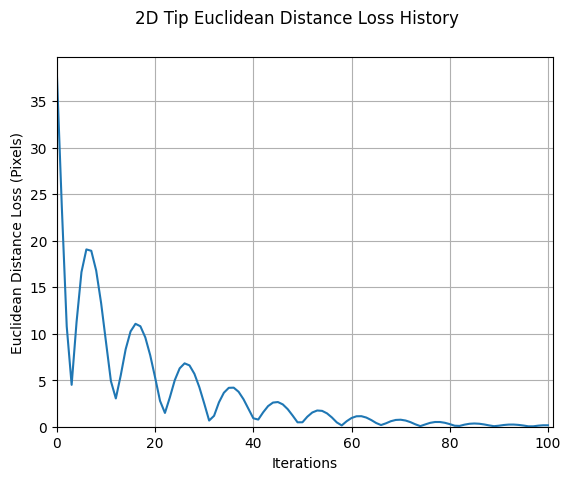

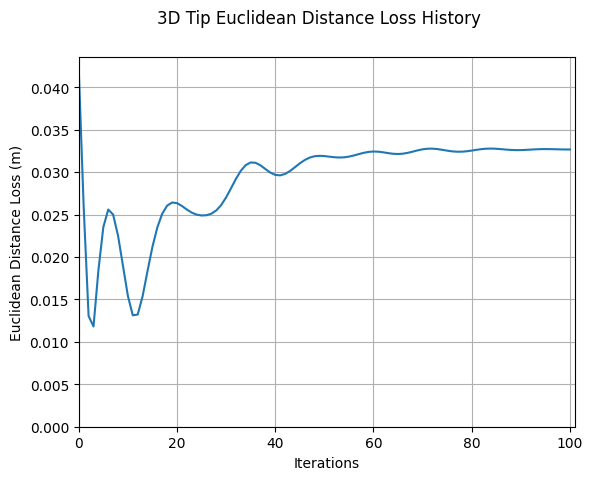

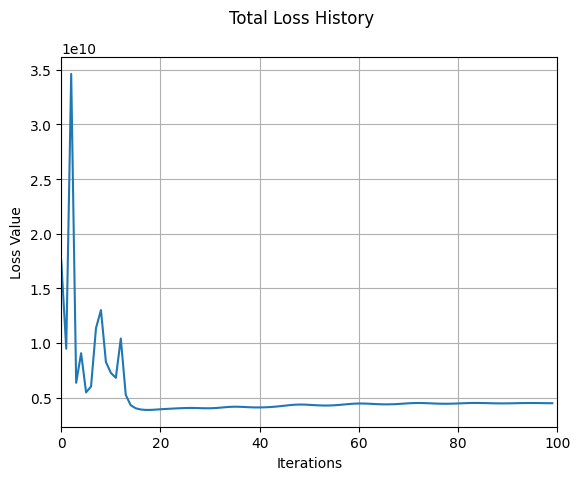

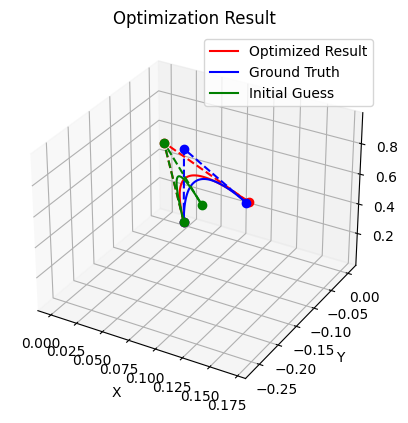

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.26s/it, loss=1.03e+10]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:02,  1.25s/it, loss=2.15e+10]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:00,  1.25s/it, loss=7e+9]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:04<01:59,  1.24s/it, loss=8.18e+9]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<01:58,  1.24s/it, loss=4.82e+9]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<01:57,  1.25s/it, loss=7.33e+9]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:08<01:57,  1.26s/it, loss=9.94e+9]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:55,  1.25s/it, loss=7.57e+9]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:54,  1.26s/it, loss=6.9e+9] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:12<01:53,  1.26s/it, loss=8.36e+9]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:13<01:52,  1.27s/it, loss=1.04e+10]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:51,  1.27s/it, loss=8.38e+9] 


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:50,  1.27s/it, loss=2.73e+10]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:17<01:49,  1.27s/it, loss=1.21e+10]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:18<01:48,  1.28s/it, loss=1.39e+10]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:20<01:47,  1.28s/it, loss=1.09e+11]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:21<01:48,  1.30s/it, loss=2.16e+10]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:22<01:46,  1.29s/it, loss=6.32e+10]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:45,  1.30s/it, loss=1.55e+10]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:25<01:43,  1.30s/it, loss=1.66e+10]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:26<01:41,  1.28s/it, loss=1.3e+10] 


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:28<01:41,  1.30s/it, loss=7.56e+9]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:29<01:38,  1.28s/it, loss=7.58e+9]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:30<01:37,  1.28s/it, loss=7.39e+9]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:31<01:35,  1.28s/it, loss=7.11e+9]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:33<01:34,  1.28s/it, loss=1.26e+10]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:34<01:33,  1.28s/it, loss=1.38e+10]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:35<01:31,  1.27s/it, loss=1.82e+10]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:36<01:30,  1.27s/it, loss=8.86e+9] 


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:38<01:38,  1.41s/it, loss=1.98e+10]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:39<01:33,  1.36s/it, loss=1.3e+10] 


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:41<01:30,  1.33s/it, loss=2.29e+10]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:42<01:28,  1.32s/it, loss=2.77e+10]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:43<01:26,  1.31s/it, loss=1.54e+10]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:45<01:25,  1.31s/it, loss=2.95e+10]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:46<01:22,  1.29s/it, loss=7.03e+10]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:47<01:20,  1.28s/it, loss=2.49e+10]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:48<01:19,  1.28s/it, loss=1.25e+10]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:50<01:18,  1.29s/it, loss=1.17e+10]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:51<01:17,  1.28s/it, loss=1.25e+10]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:52<01:15,  1.29s/it, loss=1.61e+10]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:54<01:15,  1.29s/it, loss=1.15e+10]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:55<01:13,  1.29s/it, loss=1.1e+10] 


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:56<01:11,  1.28s/it, loss=1.54e+10]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:57<01:10,  1.28s/it, loss=1.36e+10]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [00:59<01:12,  1.34s/it, loss=1.5e+10] 


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:00<01:09,  1.31s/it, loss=1.51e+10]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:01<01:07,  1.31s/it, loss=7.1e+10] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:03<01:05,  1.29s/it, loss=1.27e+10]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:04<01:04,  1.29s/it, loss=1.47e+10]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:05<01:02,  1.28s/it, loss=1.32e+10]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:06<01:01,  1.27s/it, loss=1.25e+10]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:08<00:59,  1.27s/it, loss=4.15e+10]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:09<00:58,  1.27s/it, loss=1.68e+10]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:10<00:57,  1.27s/it, loss=2.14e+10]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:12<00:55,  1.27s/it, loss=1.48e+10]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:13<00:54,  1.26s/it, loss=1.36e+10]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:14<00:53,  1.27s/it, loss=1.42e+10]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:15<00:51,  1.26s/it, loss=2.98e+10]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:17<00:50,  1.26s/it, loss=1.62e+10]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:18<00:49,  1.27s/it, loss=1.67e+10]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:19<00:47,  1.26s/it, loss=2.47e+10]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:20<00:46,  1.27s/it, loss=4.56e+10]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:22<00:45,  1.27s/it, loss=1.3e+10] 


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:23<00:46,  1.34s/it, loss=1.2e+10]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:24<00:44,  1.32s/it, loss=1.2e+10]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:26<00:43,  1.31s/it, loss=1.33e+10]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:27<00:42,  1.33s/it, loss=1.2e+11] 


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:28<00:41,  1.32s/it, loss=4.25e+10]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:30<00:39,  1.32s/it, loss=2.58e+10]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:31<00:38,  1.32s/it, loss=2.44e+10]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:32<00:36,  1.31s/it, loss=2.12e+10]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:34<00:35,  1.30s/it, loss=2.51e+10]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:35<00:33,  1.28s/it, loss=4.88e+10]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:36<00:31,  1.28s/it, loss=2e+10]   


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:37<00:30,  1.28s/it, loss=3.32e+10]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:39<00:29,  1.28s/it, loss=2.79e+10]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:40<00:27,  1.27s/it, loss=1.76e+10]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:41<00:26,  1.28s/it, loss=1.41e+10]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:42<00:25,  1.29s/it, loss=1.4e+10] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:44<00:24,  1.28s/it, loss=1.6e+10]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:45<00:23,  1.28s/it, loss=1.54e+11]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:46<00:21,  1.28s/it, loss=7.63e+10]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:48<00:20,  1.28s/it, loss=3.53e+10]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:49<00:19,  1.29s/it, loss=2.67e+10]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:50<00:18,  1.29s/it, loss=2.22e+10]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:51<00:16,  1.29s/it, loss=2.31e+10]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:53<00:15,  1.30s/it, loss=3.69e+10]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:54<00:15,  1.38s/it, loss=3.09e+10]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:56<00:13,  1.35s/it, loss=4.79e+10]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [01:57<00:11,  1.33s/it, loss=2.91e+10]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [01:58<00:10,  1.35s/it, loss=2.68e+10]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:00<00:09,  1.37s/it, loss=2e+10]   


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:01<00:08,  1.38s/it, loss=2.24e+10]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:02<00:06,  1.36s/it, loss=4.76e+11]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:04<00:05,  1.37s/it, loss=2.56e+10]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:06<00:04,  1.46s/it, loss=4.51e+10]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:07<00:02,  1.46s/it, loss=5.16e+10]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:08<00:01,  1.45s/it, loss=3.62e+10]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it, loss=3.53e+10]


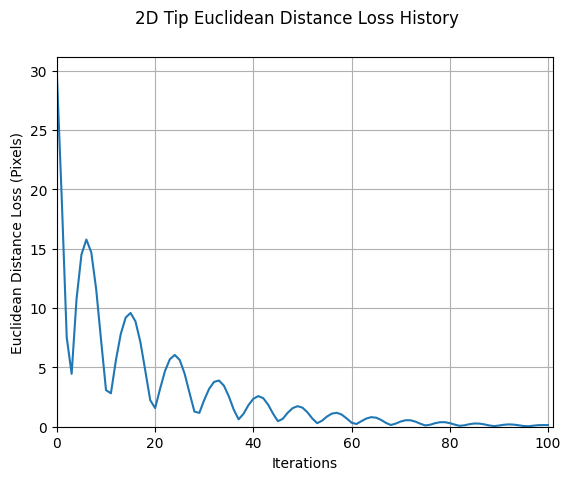

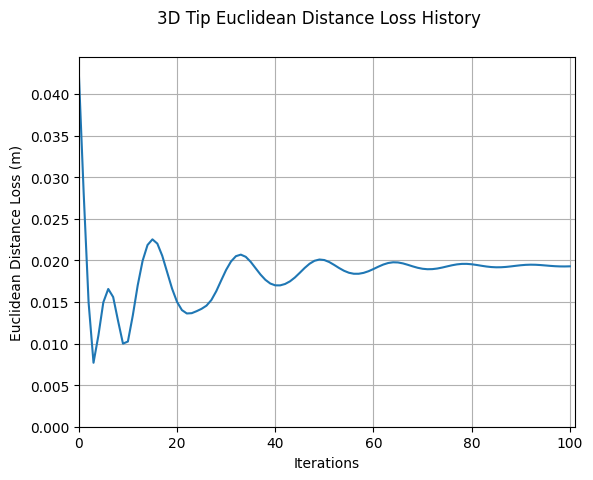

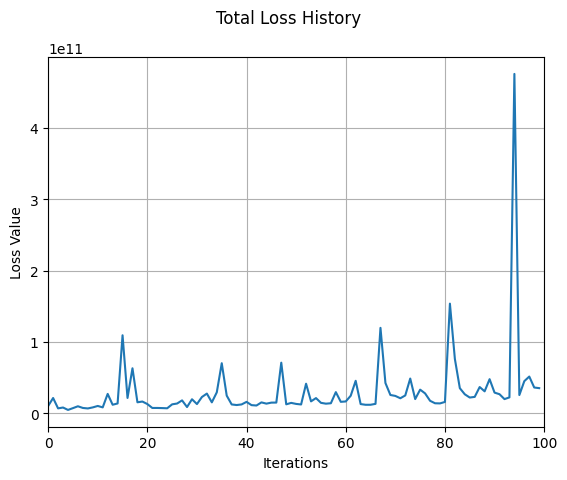

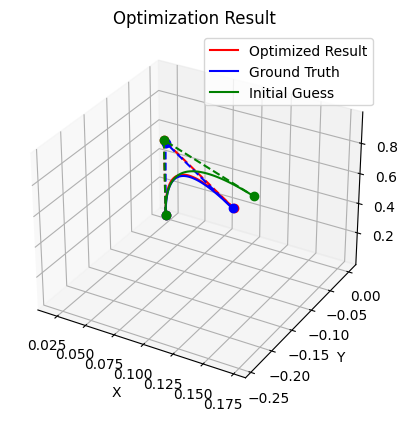

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:14,  1.36s/it, loss=8.09e+9]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<02:43,  1.67s/it, loss=5.83e+9]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:45,  1.70s/it, loss=1.18e+10]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:06<02:25,  1.52s/it, loss=5.43e+9] 


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:07<02:23,  1.51s/it, loss=1.77e+10]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:09<02:16,  1.45s/it, loss=9.48e+9] 


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:10<02:09,  1.40s/it, loss=4.98e+9]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:11<02:03,  1.35s/it, loss=1.85e+10]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:12<02:02,  1.34s/it, loss=5.68e+9] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:14<02:01,  1.35s/it, loss=1.1e+10]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:15<01:57,  1.32s/it, loss=5.17e+9]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:16<01:54,  1.30s/it, loss=7.01e+9]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:18<01:52,  1.29s/it, loss=8.88e+9]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:19<01:48,  1.27s/it, loss=6.07e+9]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:20<01:49,  1.29s/it, loss=1.02e+10]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:48,  1.30s/it, loss=1e+10]   


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:23<01:58,  1.42s/it, loss=6.5e+9]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:53,  1.39s/it, loss=4.09e+10]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:26<01:48,  1.34s/it, loss=1.34e+10]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<01:45,  1.32s/it, loss=5.96e+9] 


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:42,  1.30s/it, loss=6.16e+9]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:40,  1.28s/it, loss=9.98e+9]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:37,  1.27s/it, loss=8.53e+9]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:36,  1.27s/it, loss=1.21e+10]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:34,  1.27s/it, loss=7.26e+9] 


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:34<01:33,  1.26s/it, loss=3.28e+10]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:32,  1.26s/it, loss=8.78e+9] 


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:30,  1.26s/it, loss=7.05e+9]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:38<01:29,  1.26s/it, loss=3.33e+10]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:31,  1.31s/it, loss=8.19e+9] 


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:29,  1.30s/it, loss=1.06e+10]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:27,  1.29s/it, loss=7.25e+9] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:43<01:25,  1.28s/it, loss=2.99e+10]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:45<01:25,  1.29s/it, loss=2.12e+10]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:46<01:25,  1.32s/it, loss=7.97e+9] 


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:47<01:24,  1.32s/it, loss=1.11e+10]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:49<01:22,  1.32s/it, loss=1.76e+10]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:50<01:20,  1.30s/it, loss=6.1e+9]  


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:51<01:18,  1.28s/it, loss=5.36e+9]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:53<01:16,  1.28s/it, loss=5.31e+9]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:54<01:14,  1.27s/it, loss=5.38e+9]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:55<01:13,  1.27s/it, loss=5.37e+9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:56<01:11,  1.25s/it, loss=5.31e+9]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:58<01:10,  1.26s/it, loss=5.36e+9]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:59<01:09,  1.26s/it, loss=5.82e+9]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:00<01:11,  1.33s/it, loss=9.28e+9]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:02<01:08,  1.30s/it, loss=8.54e+9]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:03<01:07,  1.29s/it, loss=1e+10]  


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:04<01:07,  1.33s/it, loss=9.39e+9]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:06<01:07,  1.36s/it, loss=1.03e+10]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:07<01:04,  1.31s/it, loss=9.44e+9] 


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:08<01:01,  1.29s/it, loss=1.38e+10]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:09<00:59,  1.27s/it, loss=7.5e+9]  


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:11<00:58,  1.28s/it, loss=8.24e+9]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:12<00:59,  1.32s/it, loss=9.12e+9]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:13<00:56,  1.29s/it, loss=5.8e+9] 


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:14<00:54,  1.26s/it, loss=5.43e+9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:16<00:54,  1.31s/it, loss=5.33e+9]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:17<00:52,  1.28s/it, loss=5.31e+9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:18<00:50,  1.26s/it, loss=5.33e+9]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:20<00:48,  1.26s/it, loss=5.33e+9]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:21<00:47,  1.25s/it, loss=5.31e+9]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:22<00:45,  1.23s/it, loss=5.35e+9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:23<00:44,  1.24s/it, loss=5.48e+9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:24<00:43,  1.24s/it, loss=5.8e+9] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:26<00:45,  1.33s/it, loss=6.5e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:27<00:43,  1.31s/it, loss=8.44e+9]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:29<00:41,  1.29s/it, loss=1.4e+10]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:30<00:39,  1.29s/it, loss=1.09e+10]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:31<00:37,  1.26s/it, loss=7.5e+9]  


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:32<00:38,  1.32s/it, loss=6.39e+9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:34<00:37,  1.34s/it, loss=5.9e+9] 


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:35<00:35,  1.32s/it, loss=5.63e+9]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:36<00:33,  1.30s/it, loss=5.47e+9]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:38<00:33,  1.33s/it, loss=5.39e+9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:39<00:33,  1.40s/it, loss=5.34e+9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:41<00:31,  1.39s/it, loss=5.33e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:42<00:29,  1.35s/it, loss=5.33e+9]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:43<00:28,  1.36s/it, loss=5.34e+9]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:45<00:26,  1.35s/it, loss=5.36e+9]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:46<00:25,  1.34s/it, loss=5.42e+9]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:47<00:23,  1.31s/it, loss=5.5e+9] 


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:49<00:22,  1.30s/it, loss=5.6e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:50<00:20,  1.28s/it, loss=5.68e+9]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:51<00:18,  1.27s/it, loss=5.73e+9]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:52<00:17,  1.26s/it, loss=5.73e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:54<00:16,  1.27s/it, loss=5.69e+9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:55<00:15,  1.25s/it, loss=5.63e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:56<00:13,  1.24s/it, loss=5.55e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:57<00:13,  1.32s/it, loss=5.49e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [01:59<00:11,  1.30s/it, loss=5.43e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:00<00:10,  1.27s/it, loss=5.4e+9] 


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:01<00:08,  1.26s/it, loss=5.38e+9]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:02<00:07,  1.25s/it, loss=5.37e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:04<00:06,  1.24s/it, loss=5.38e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:05<00:04,  1.24s/it, loss=5.39e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:06<00:03,  1.24s/it, loss=5.42e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:07<00:02,  1.23s/it, loss=5.45e+9]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:09<00:01,  1.23s/it, loss=5.49e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it, loss=5.51e+9]


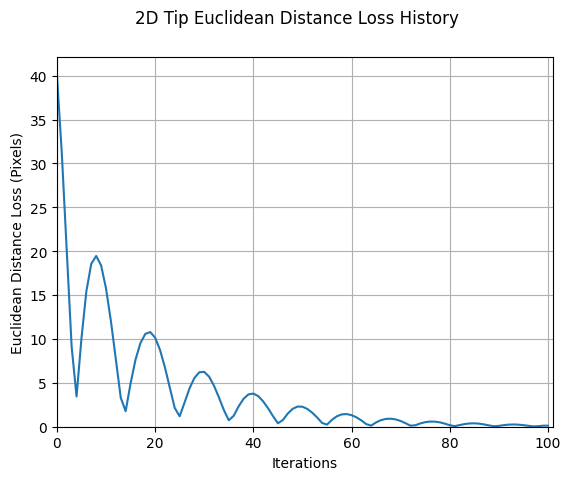

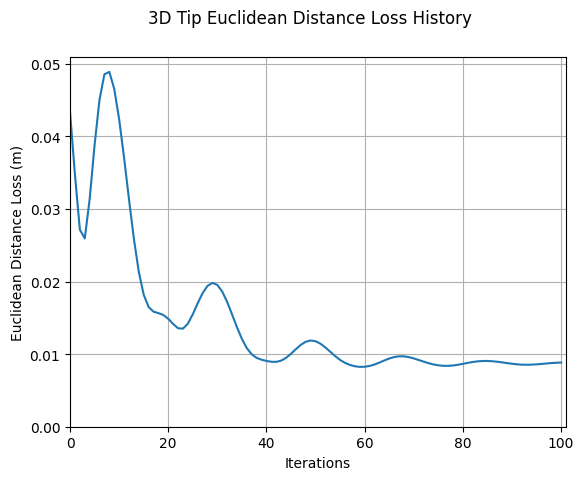

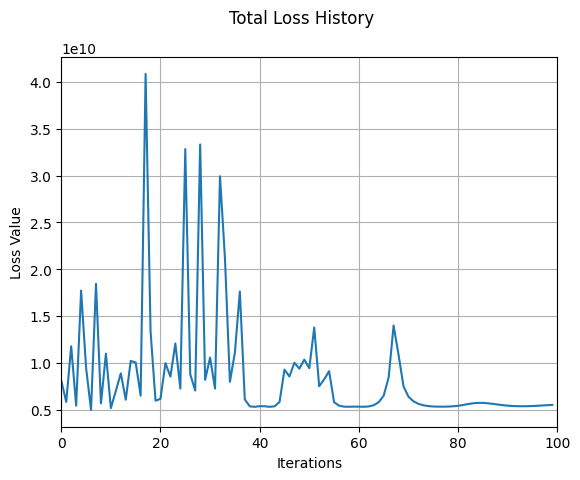

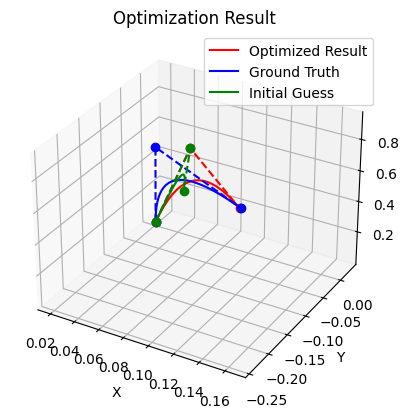

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:01,  1.22s/it, loss=8.82e+9]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<01:57,  1.20s/it, loss=9.73e+9]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<01:58,  1.22s/it, loss=1.51e+10]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:04<01:58,  1.24s/it, loss=1.09e+10]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<01:56,  1.23s/it, loss=1.17e+10]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<01:55,  1.22s/it, loss=9.23e+9] 


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:08<01:53,  1.22s/it, loss=8.53e+9]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:09<01:51,  1.21s/it, loss=1.14e+10]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:10<01:50,  1.22s/it, loss=6.17e+9] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:12<01:50,  1.22s/it, loss=8.4e+9]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:13<01:51,  1.25s/it, loss=9.89e+9]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:14<01:50,  1.25s/it, loss=8.57e+9]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:15<01:47,  1.24s/it, loss=2e+10]  


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:17<01:46,  1.23s/it, loss=9.09e+9]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:18<01:46,  1.25s/it, loss=9.28e+9]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:19<01:45,  1.25s/it, loss=1.53e+10]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:21<01:43,  1.25s/it, loss=6.91e+9] 


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:22<01:44,  1.27s/it, loss=1.12e+10]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:24<01:55,  1.43s/it, loss=7.23e+9] 


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:25<01:51,  1.40s/it, loss=1.68e+10]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:26<01:46,  1.35s/it, loss=6.94e+9] 


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:27<01:42,  1.31s/it, loss=8.01e+9]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:29<01:38,  1.29s/it, loss=1.52e+10]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:30<01:35,  1.26s/it, loss=1.09e+10]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:31<01:34,  1.26s/it, loss=1.21e+10]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:32<01:32,  1.24s/it, loss=9.32e+9] 


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:34<01:30,  1.24s/it, loss=2.59e+11]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:35<01:28,  1.23s/it, loss=1.62e+10]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:36<01:27,  1.23s/it, loss=1.07e+10]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:37<01:25,  1.22s/it, loss=9.83e+9] 


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:38<01:24,  1.22s/it, loss=1.86e+10]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:40<01:26,  1.28s/it, loss=4.63e+10]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:41<01:25,  1.28s/it, loss=1.33e+10]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:42<01:25,  1.29s/it, loss=8.24e+9] 


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:44<01:22,  1.27s/it, loss=6.48e+9]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:45<01:21,  1.27s/it, loss=7.88e+9]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:46<01:18,  1.25s/it, loss=7.78e+9]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:47<01:16,  1.24s/it, loss=9.69e+9]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:49<01:18,  1.29s/it, loss=8.53e+9]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:50<01:19,  1.33s/it, loss=7.79e+9]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:51<01:18,  1.32s/it, loss=7.28e+9]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:53<01:16,  1.32s/it, loss=6.38e+9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:54<01:16,  1.35s/it, loss=6.77e+9]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:56<01:18,  1.40s/it, loss=9.38e+9]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:57<01:15,  1.37s/it, loss=1.66e+10]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [00:58<01:11,  1.33s/it, loss=1.79e+10]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [00:59<01:08,  1.30s/it, loss=1.52e+10]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:01<01:09,  1.34s/it, loss=1.97e+10]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:02<01:06,  1.31s/it, loss=1.57e+10]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:03<01:04,  1.29s/it, loss=8.6e+9]  


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:05<01:02,  1.28s/it, loss=6.68e+9]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:06<01:00,  1.26s/it, loss=6.38e+9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:07<00:59,  1.26s/it, loss=7.3e+9] 


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:08<00:57,  1.25s/it, loss=8.2e+9]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:10<00:56,  1.25s/it, loss=7.37e+9]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:11<00:54,  1.24s/it, loss=7.4e+9] 


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:12<00:52,  1.23s/it, loss=7.79e+9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:13<00:51,  1.22s/it, loss=1.31e+10]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:14<00:49,  1.22s/it, loss=6.85e+9] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:16<00:48,  1.22s/it, loss=6.44e+9]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:17<00:47,  1.22s/it, loss=6.38e+9]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:18<00:46,  1.23s/it, loss=6.44e+9]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:19<00:45,  1.22s/it, loss=6.51e+9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:21<00:43,  1.22s/it, loss=6.55e+9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:22<00:42,  1.22s/it, loss=6.52e+9]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:23<00:41,  1.22s/it, loss=6.45e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:24<00:40,  1.24s/it, loss=6.39e+9]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:26<00:41,  1.31s/it, loss=6.41e+9]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:27<00:40,  1.29s/it, loss=6.62e+9]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:28<00:38,  1.28s/it, loss=7.35e+9]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:29<00:36,  1.27s/it, loss=1.18e+10]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:31<00:35,  1.26s/it, loss=1.65e+10]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:32<00:35,  1.30s/it, loss=2.25e+10]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:34<00:34,  1.33s/it, loss=1e+10]   


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:35<00:32,  1.32s/it, loss=7.27e+9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:36<00:32,  1.36s/it, loss=6.67e+9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:38<00:30,  1.33s/it, loss=6.47e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:39<00:29,  1.35s/it, loss=6.4e+9] 


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:40<00:28,  1.36s/it, loss=6.38e+9]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:42<00:27,  1.35s/it, loss=6.37e+9]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:43<00:26,  1.37s/it, loss=6.37e+9]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:44<00:24,  1.38s/it, loss=6.4e+9] 


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:46<00:23,  1.37s/it, loss=6.47e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:47<00:21,  1.37s/it, loss=6.6e+9] 


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:48<00:20,  1.34s/it, loss=6.8e+9]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:50<00:18,  1.34s/it, loss=7.07e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:51<00:17,  1.34s/it, loss=7.34e+9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:52<00:15,  1.32s/it, loss=7.46e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:54<00:14,  1.30s/it, loss=7.34e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:55<00:13,  1.36s/it, loss=7.08e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [01:56<00:11,  1.32s/it, loss=6.83e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [01:58<00:11,  1.42s/it, loss=6.65e+9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [01:59<00:09,  1.38s/it, loss=6.54e+9]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:01<00:08,  1.37s/it, loss=6.48e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:02<00:06,  1.37s/it, loss=6.46e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:03<00:05,  1.36s/it, loss=6.47e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:05<00:04,  1.38s/it, loss=6.51e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:06<00:02,  1.38s/it, loss=6.57e+9]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:08<00:01,  1.37s/it, loss=6.67e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it, loss=6.8e+9]


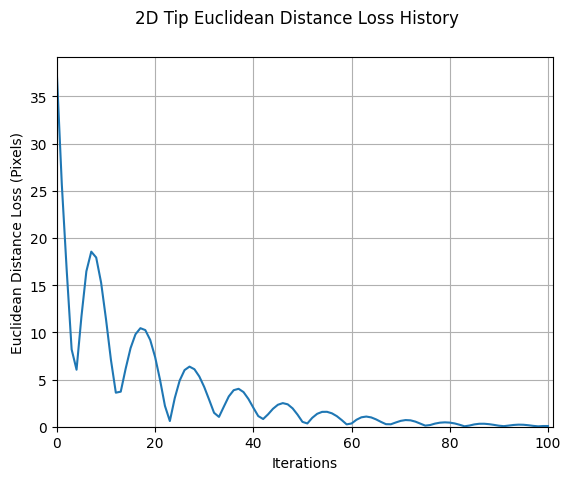

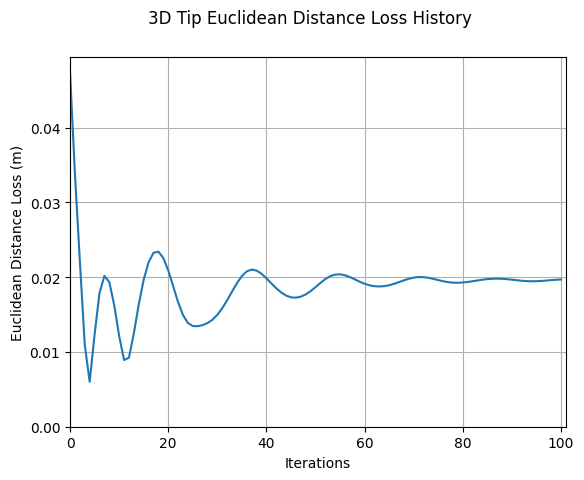

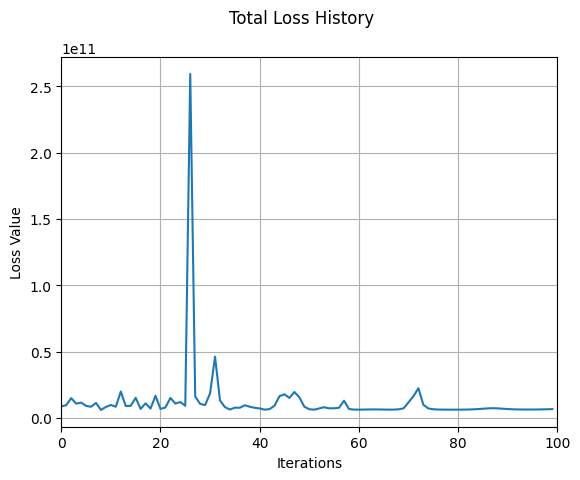

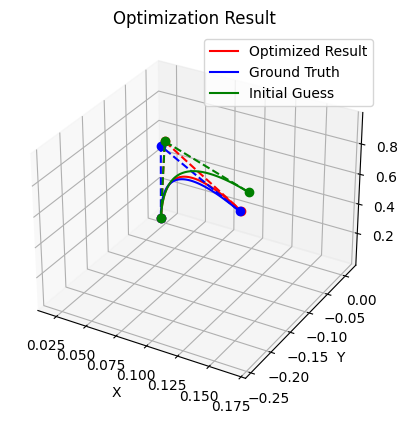

  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:09,  1.31s/it, loss=2.71e+9]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:09,  1.32s/it, loss=1.43e+9]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:04<02:13,  1.38s/it, loss=3.5e+9] 


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:10,  1.36s/it, loss=3.4e+9]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<02:05,  1.32s/it, loss=1.91e+9]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:08<02:04,  1.33s/it, loss=2.34e+9]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:09<02:06,  1.36s/it, loss=9.74e+10]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<02:02,  1.33s/it, loss=3.07e+9] 


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:59,  1.31s/it, loss=3.66e+9]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:13<01:58,  1.32s/it, loss=3.7e+9]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:57,  1.32s/it, loss=2.31e+9]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:55,  1.31s/it, loss=2.42e+9]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:17<01:54,  1.32s/it, loss=3.01e+9]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:55,  1.34s/it, loss=2.01e+9]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:54,  1.34s/it, loss=1.87e+9]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:54,  1.36s/it, loss=1.83e+9]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:50,  1.33s/it, loss=1.83e+9]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:24<01:49,  1.34s/it, loss=1.85e+9]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:57,  1.45s/it, loss=1.93e+9]


loop_id:  19


Optimizing:  20%|██        | 20/100 [00:27<02:00,  1.51s/it, loss=2.13e+9]


loop_id:  20


Optimizing:  21%|██        | 21/100 [00:28<01:54,  1.45s/it, loss=3.13e+9]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:30<01:59,  1.54s/it, loss=3.08e+9]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:31<01:57,  1.53s/it, loss=3.23e+9]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:33<01:58,  1.56s/it, loss=6.25e+9]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:34<01:52,  1.50s/it, loss=2.86e+9]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:36<01:47,  1.46s/it, loss=2.57e+9]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:37<01:42,  1.41s/it, loss=2.53e+9]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:38<01:38,  1.36s/it, loss=2.58e+9]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:40<01:35,  1.34s/it, loss=2.69e+9]


loop_id:  29


Optimizing:  30%|███       | 30/100 [00:41<01:32,  1.32s/it, loss=2.84e+9]


loop_id:  30


Optimizing:  31%|███       | 31/100 [00:42<01:29,  1.30s/it, loss=3.03e+9]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:43<01:28,  1.30s/it, loss=3.2e+9] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:45<01:27,  1.30s/it, loss=3.28e+9]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:46<01:25,  1.29s/it, loss=3.2e+9] 


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:47<01:27,  1.34s/it, loss=3.02e+9]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:49<01:24,  1.32s/it, loss=2.84e+9]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:50<01:22,  1.31s/it, loss=2.7e+9] 


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:21,  1.32s/it, loss=2.61e+9]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:53<01:20,  1.31s/it, loss=2.56e+9]


loop_id:  39


Optimizing:  40%|████      | 40/100 [00:54<01:18,  1.31s/it, loss=2.55e+9]


loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:17,  1.31s/it, loss=2.55e+9]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:57<01:14,  1.29s/it, loss=2.57e+9]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:58<01:13,  1.29s/it, loss=2.66e+9]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:12,  1.29s/it, loss=2.88e+9]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:00<01:10,  1.28s/it, loss=3.57e+9]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:02<01:09,  1.28s/it, loss=2.67e+10]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:07,  1.27s/it, loss=4.36e+9] 


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:04<01:06,  1.28s/it, loss=4.2e+9] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:05<01:05,  1.28s/it, loss=4.76e+9]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:04,  1.28s/it, loss=5.12e+9]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:08<01:02,  1.27s/it, loss=4.69e+9]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:10<01:04,  1.34s/it, loss=4.19e+9]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:11<01:02,  1.33s/it, loss=4.3e+9] 


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:12<01:01,  1.33s/it, loss=8.02e+9]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:13<00:59,  1.32s/it, loss=6.1e+9] 


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:15<00:57,  1.31s/it, loss=3.99e+9]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:16<00:56,  1.30s/it, loss=3.62e+9]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:17<00:54,  1.29s/it, loss=3.69e+9]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:19<00:53,  1.30s/it, loss=4.31e+9]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:20<00:54,  1.37s/it, loss=8.85e+9]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:21<00:52,  1.34s/it, loss=6.25e+9]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:23<00:50,  1.34s/it, loss=4.27e+9]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:24<00:49,  1.34s/it, loss=4.16e+9]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:25<00:48,  1.36s/it, loss=4.44e+9]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:27<00:47,  1.35s/it, loss=4.71e+9]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:28<00:45,  1.34s/it, loss=4.67e+9]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:29<00:43,  1.33s/it, loss=4.39e+9]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:31<00:42,  1.32s/it, loss=4.17e+9]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:32<00:41,  1.33s/it, loss=4.14e+9]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:33<00:39,  1.32s/it, loss=4.36e+9]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:35<00:38,  1.32s/it, loss=4.79e+9]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:36<00:37,  1.33s/it, loss=5.21e+9]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:38<00:37,  1.41s/it, loss=5.24e+9]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:39<00:35,  1.37s/it, loss=4.89e+9]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:40<00:33,  1.35s/it, loss=4.51e+9]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:42<00:32,  1.34s/it, loss=4.26e+9]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:43<00:32,  1.40s/it, loss=4.15e+9]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:44<00:29,  1.35s/it, loss=4.13e+9]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:46<00:28,  1.34s/it, loss=4.15e+9]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:47<00:26,  1.32s/it, loss=4.16e+9]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:48<00:25,  1.33s/it, loss=4.15e+9]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:50<00:24,  1.35s/it, loss=4.14e+9]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:51<00:22,  1.34s/it, loss=4.13e+9]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:52<00:21,  1.35s/it, loss=4.13e+9]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:54<00:20,  1.35s/it, loss=4.13e+9]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:55<00:18,  1.34s/it, loss=4.13e+9]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:56<00:17,  1.37s/it, loss=4.14e+9]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:58<00:16,  1.38s/it, loss=4.15e+9]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:59<00:15,  1.37s/it, loss=4.15e+9]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [02:00<00:13,  1.35s/it, loss=4.15e+9]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:02<00:12,  1.33s/it, loss=4.15e+9]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:03<00:10,  1.35s/it, loss=4.15e+9]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:05<00:09,  1.36s/it, loss=4.14e+9]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:06<00:08,  1.39s/it, loss=4.14e+9]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:07<00:07,  1.41s/it, loss=4.13e+9]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:09<00:05,  1.39s/it, loss=4.13e+9]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:10<00:04,  1.39s/it, loss=4.13e+9]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:12<00:02,  1.38s/it, loss=4.14e+9]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:13<00:01,  1.46s/it, loss=4.15e+9]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it, loss=4.14e+9]


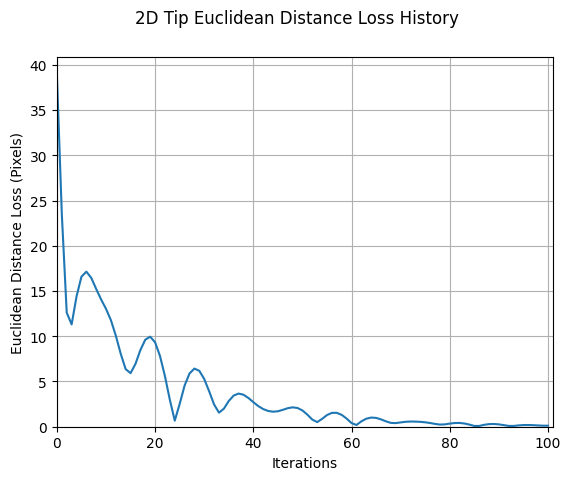

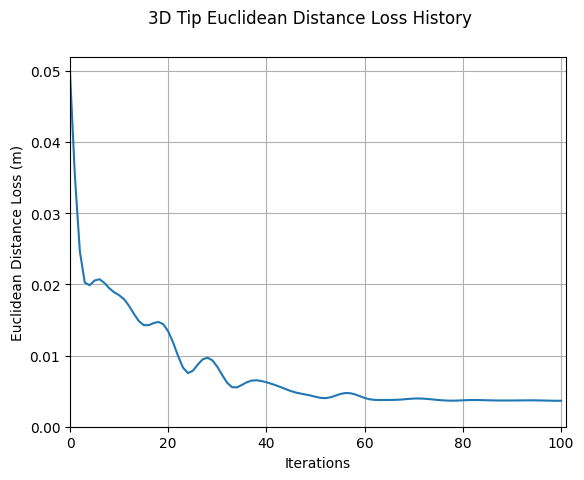

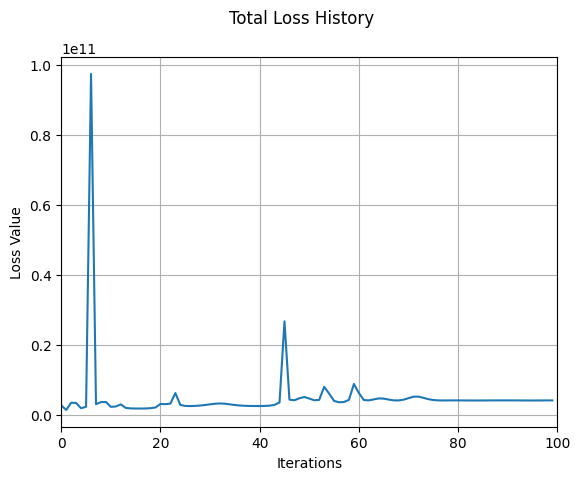

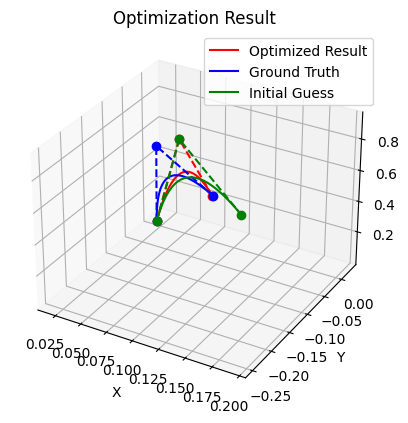

In [5]:
# para_init_0 = np.array([0.0365, 0.0036, 0.1202, 0.0056, -0.0166, 0.1645], dtype=np.float32)
# para_init_1 = np.array([0.03, 0.0055, 0.0702, 0.0206, -0.0306, 0.1845], dtype=np.float32)
# para_init_3 = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0306, 0.1815], dtype=np.float32)
para_init_list = vectors

for i, para_init in enumerate(para_init_list):
    excecute(para_init, i+1)